In [96]:
import torch
import torchvision
from torchvision import transforms, utils, models
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
from random import randint

import psycopg2,datetime,heapq

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib

import os
import shutil

from sklearn.manifold import TSNE

import seaborn as sns

import random
import ipyplot
from tqdm import tqdm
from livelossplot import PlotLosses

torch.manual_seed(4096)

In [2]:
conn = psycopg2.connect(database="trademark1", user="tm_root", password="roottm_9823a", host="trueint.lu.im.ntu.edu.tw", port="5433")
cur = conn.cursor()

In [3]:
%%time
caseno_list = []
cur.execute("SELECT trademark.caseno, trademark.doc, trademark.Trademark_Design, rcc.Class, rcp.FileName, \
            rcc.goods_denomination, img_content.category \
            FROM trademark  INNER JOIN  rcc ON (trademark.caseno = rcc.caseno) \
             INNER JOIN rcp ON ( trademark.caseno = rcp.caseno  ) \
             INNER JOIN text ON (trademark.caseno = text.caseno) \
             INNER JOIN img_content ON ( trademark.caseno = img_content.caseno )\
where ( text.chinese is null and text.english is null and text.japanese is null and text.symbol is null) \
        ") 
r = cur.fetchall()

CPU times: user 185 ms, sys: 71.3 ms, total: 256 ms
Wall time: 859 ms


In [4]:
caseno_list += [i for i in r]
len(caseno_list)

120390

In [5]:
data = pd.DataFrame(caseno_list, columns=['caseno', 'doc', 'design', 'class', 'filename','goods_denomination', 'content'])
data['path'] = '/service/trademark/raw_register_data/' + data.doc+ '/' + data.filename
data.dropna(inplace=True)
data.to_csv('img_index.csv', index=False)

In [6]:
data[data.caseno == 103072894]

caseno                      doc    design  class  \
15674  103072894  TrademarkRegXMLB_042013  (彩色)(平面)   45.0   
15675  103072894  TrademarkRegXMLB_042013  (彩色)(平面)   45.0   

                                      filename  \
15674  imagesdata/egimg_103072894_1_042013.jpg   
15675  imagesdata/egimg_103072894_1_042013.jpg   

                                      goods_denomination  content  \
15674  喪葬服務、代辦喪葬事宜、喪禮禮堂佈置、葬儀社、火葬場服務、預定殯葬服務、殯儀服務、殯葬會場出...  12-A-00   
15675  喪葬服務、代辦喪葬事宜、喪禮禮堂佈置、葬儀社、火葬場服務、預定殯葬服務、殯儀服務、殯葬會場出...  02-D-00   

                                                    path  
15674  /service/trademark/raw_register_data/Trademark...  
15675  /service/trademark/raw_register_data/Trademark...

## EDA

In [7]:
# 隨機印出各種圖片
def show_img_design(design, num=4):
    imgs = []
    a = list(data[data.design==design]['path'])
    if len(a) <= num:
        for i in a:
            img = Image.open( i )
            img = img.resize((128, 128), Image.ANTIALIAS)
            imgs.append(img)
    else:
        for i in range(num):
            img = Image.open( random.choice(a) )
            img = img.resize((128, 128), Image.ANTIALIAS)
            imgs.append(img)
    ipyplot.plot_images(imgs, max_images=num)
#     display(imgs)

In [8]:
data = pd.read_csv('img_index.csv')
print(f"有{data.caseno.value_counts().shape[0]}張圖片")
# data = data[ data['design'] =='(彩色)(平面)' ]

有46005張圖片


In [9]:
# data = data[(data['design'] == '(墨色)(平面)') | ( data['design'] =='(彩色)(平面)' )]
data = data[ data['design'] =='(彩色)(平面)' ].drop_duplicates(keep='first')

In [10]:
print(f"彩色平面有{data.caseno.value_counts().shape[0]}張")
print(f"total numbers of labels :{data.content.value_counts().shape[0]}")

彩色平面有13799張
total numbers of labels :97


In [11]:
# data.drop(columns=['filename','goods_denomination', 'class', 'design', 'goods_denomination', 'doc'],inplace=True)
# data.drop_duplicates(keep='first', inplace=True)

## Multi-hot encoding

### 為了解決重複問題 新增兩張表 df_path & df_labels

In [12]:
a = pd.concat([data.caseno, pd.get_dummies(data.content)], axis=1).groupby('caseno').sum()
# max(a)
df_labels = a.astype('float32')
df_labels

01-A-00  01-B-00  01-C-00  01-D-00  01-E-00  01-F-00  01-G-00  \
caseno                                                                     
99000467       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
99001415       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
99001623       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
99005152       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
99007594       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...            ...      ...      ...      ...      ...      ...      ...   
109071468      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
109071857      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
109072030      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
109880652      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
109880654      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

           01-H-00  02-A-00  02-B-00  ...  12-D-00  12-E-00  12-F-00  12-G-00  \
caseno                                ...                                       
99000467       0.0      0.0      0.0  ...      1.0      0.0      0.0      0.0   
99001415       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
99001623       0.0      0.0      0.0  ...      0.0      0.0      5.0      0.0   
99005152       0.0      2.0      0.0  ...      0.0      0.0      0.0      0.0   
99007594       0.0      0.0      0.0  ...      0.0      1.0      0.0      0.0   
...            ...      ...      ...  ...      ...      ...      ...      ...   
109071468      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
109071857      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
109072030      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
109880652      1.0      0.0      0.0  ...      0.0      0.0      0.0      1.0   
109880654      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   

           12-H-00  13-A-00  13-B-00  13-F-00  13-L-00  14-A-00  
caseno                                                           
99000467       0.0      0.0      0.0      0.0      0.0      0.0  
99001415       0.0      0.0      0.0      0.0      0.0      0.0  
99001623       0.0      0.0      0.0      0.0      0.0      0.0  
99005152       0.0      0.0      0.0      0.0      0.0      0.0  
99007594       0.0      0.0      0.0      0.0      0.0      0.0  
...            ...      ...      ...      ...      ...      ...  
109071468      0.0      0.0      0.0      0.0      0.0      0.0  
109071857      0.0      0.0      0.0      0.0      0.0      0.0  
109072030      0.0      0.0      0.0      0.0      0.0      0.0  
109880652      0.0      0.0      0.0      0.0      0.0      0.0  
109880654      0.0      0.0      0.0      0.0      0.0      0.0  

[13799 rows x 97 columns]

In [13]:
df_path = data[['caseno', 'filename', 'path' ]].drop_duplicates().set_index('caseno')
df_path

filename  \
caseno                                               
99058204   imagesdata/egimg_099058204_1_038017.jpg   
99053384   imagesdata/egimg_099053384_1_038017.jpg   
99023943   imagesdata/egimg_099023943_1_038017.jpg   
99047384   imagesdata/egimg_099047384_1_038017.jpg   
99063161   imagesdata/egimg_099063161_1_038017.jpg   
...                                            ...   
105067727  imagesdata/egimg_105067727_1_044014.jpg   
105076024  imagesdata/egimg_105076024_1_044014.jpg   
106000500  imagesdata/egimg_106000500_1_044015.jpg   
106008977  imagesdata/egimg_106008977_1_044018.jpg   
106006498  imagesdata/egimg_106006498_1_044018.jpg   

                                                        path  
caseno                                                        
99058204   /service/trademark/raw_register_data/Trademark...  
99053384   /service/trademark/raw_register_data/Trademark...  
99023943   /service/trademark/raw_register_data/Trademark...  
99047384   /service/trademark/raw_register_data/Trademark...  
99063161   /service/trademark/raw_register_data/Trademark...  
...                                                      ...  
105067727  /service/trademark/raw_register_data/Trademark...  
105076024  /service/trademark/raw_register_data/Trademark...  
106000500  /service/trademark/raw_register_data/Trademark...  
106008977  /service/trademark/raw_register_data/Trademark...  
106006498  /service/trademark/raw_register_data/Trademark...  

[13799 rows x 2 columns]

In [ ]:
df_labels.to_csv('labels.csv', index=True)
df_path.to_csv('path.csv', index=True)

In [7]:
df_labels = pd.read_csv('labels.csv',index_col='caseno')
df_path = pd.read_csv('path.csv',index_col='caseno')
# df_path

In [16]:
df_merge = pd.concat([df_path, df_labels], axis=1)

In [93]:
def readgroup():
    #Group List
    #os.chdir('/home/jack/4_Selenium')
    with open("top.txt",encoding="utf-8") as f:
        top = f.read().split("\n")
    with open("all.txt",encoding="utf-8") as f:
        allg = f.read().split("\n")
    #print(top,allg)

    run = {}
    for x in allg:
        #print(x)
        if x in top:
            head = x[:2]
            #print(head)
        else:
            #run.append((head+"-"+x[1]+"-00",x[3:]))
            run[head+"-"+x[1]+"-00"] = x[3:]
    # for i in run:
    #     print(i)
    #print(len(run))
    return run
labels_dict = readgroup()
# labels_dict

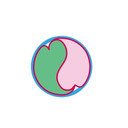

106002535
圓形外觀 ; 特定形狀圖形


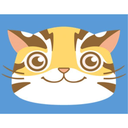

105017539
走獸


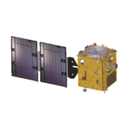

109048547
通信設備(電話.天線.碟形天線.人造衛星.麥克風)


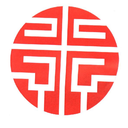

100014687
圓形外觀


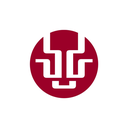

109012981
假想獸及古代動物 ; 圓形外觀 ; 線條/曲折區塊或其與幾何圖形之組合/重疊(對稱係指整體構圖而言)


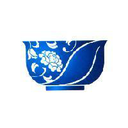

101059858
花/葉/草 ; 廚房設備/器皿(叉.盆.碗.壺.瓶.汽水瓶.鼎.尊.花瓶.杯子.杵臼)


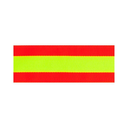

104043932
四角形外觀


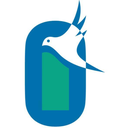

108020790
飛禽/蝙蝠 ; 圓形外觀


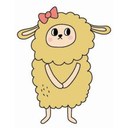

103048951
擬人化 ; 走獸


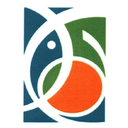

102060993
水族 ; 四角形外觀 ; 不同幾何形狀組合/重疊或其他不規則圖形(不包含線條)


In [18]:
for i in df_labels.sample(10).index:
    labels = []
    for j in df_labels.columns:
        if df_labels.loc[i][j] > 0:
            labels.append(j)
    a = [labels_dict[i] for i in labels]
    img = Image.open(df_merge.loc[i].path)
    img = img.resize((128,128),Image.ANTIALIAS)
    display(img)
    print(i)
    print(f"{' ; '.join(a)}")

## Load image

In [2]:
df_labels = pd.read_csv('labels.csv',index_col='caseno')
df_path = pd.read_csv('path.csv',index_col='caseno')
# df_path

In [197]:
class train_set(Dataset):
    def __init__(self, df_labels, df_path, transform):
        self.df_merge = pd.concat([df_path, df_labels], axis=1)
        self.df_merge = self.df_merge[:int(self.df_merge.shape[0]*0.8)]
        self.transform = transform
        self.labels = self.df_merge.drop(columns=['filename', 'path']).values
        self.labels = self.labels.astype('float32')
        self.path = self.df_merge[['path']].values
    
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        image = Image.open(self.path[idx][0]).convert('RGB')
        label = self.labels[idx]
        image = self.transform(image)
        return image, label

class test_set(Dataset):
    def __init__(self, df_labels, df_path, transform):
        self.df_merge = pd.concat([df_path, df_labels], axis=1)
        self.df_merge = self.df_merge[int(self.df_merge.shape[0]*0.8):]
        self.transform = transform
        self.labels = self.df_merge.drop(columns=['filename', 'path']).values
        self.labels = self.labels.astype('float32')
        self.path = self.df_merge[['path']].values
        self.label_code = self.df_merge.drop(columns=['filename', 'path']).columns
    
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        image = Image.open(self.path[idx][0]).convert('RGB')
        label = self.labels[idx]
        image = self.transform(image)
        
        return image, label
    


In [198]:
train_data = train_set(df_labels, df_path, transform=transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))
test_data = test_set(df_labels, df_path, transform=transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))

In [199]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=False)
print(len(train_loader))
print(len(test_loader))

690
2760


In [15]:
df_labels.values.dtype

dtype('float64')

In [227]:
# # Display image and label.
# train_features, train_labels = next(iter(train_loader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].squeeze().numpy()
# img = np.transpose(img, (1, 2, 0))
# labels = []
# for i, j in enumerate(train_labels[0]):
#     if j > 0:
#         labels.append(df_labels.columns[i])
# label = [labels_dict[i] for i in labels]
# plt.imshow(img)
# plt.show()
# print(f"Label: {' ; '.join(label)}")

In [228]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features 
model.fc = torch.nn.Linear(num_ftrs, len(df_labels.columns))


model = model.to(device)
# model.eval()
# model.training

# 固定除了最後 12 layer
# lr 調小
# SGD

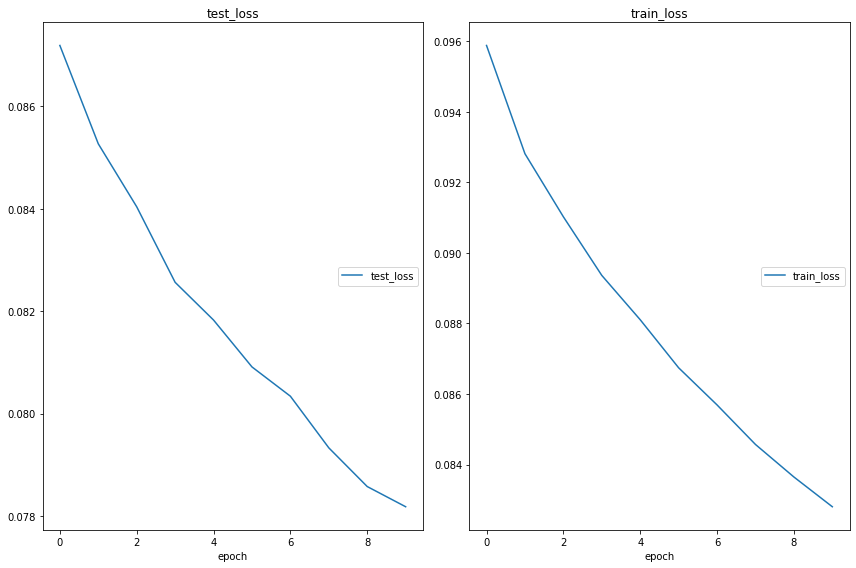

test_loss
	test_loss        	 (min:    0.078, max:    0.087, cur:    0.078)
train_loss
	train_loss       	 (min:    0.083, max:    0.096, cur:    0.083)
Finished Training
CPU times: user 1h 43min 19s, sys: 1min 2s, total: 1h 44min 21s
Wall time: 21min 32s


In [232]:
%%time
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)


num_epochs = 10
liveloss = PlotLosses()

# Train
for epoch in range(num_epochs):
    print("epoch :", epoch)
    logs = {}
    running_loss = 0.0
#     train_accs = []
#     test_accs = []
    test_loss = []
    model.train()
    for times, data in enumerate(tqdm(train_loader)):
        model.train()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
#         acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()
#         train_accs.append(acc)
        loss = criterion(outputs, labels)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        

    logs['train_loss'] = running_loss/times
#     logs['train_accracy'] = sum(train_accs) / len(train_accs)
    with torch.no_grad():
        for data in tqdm(test_loader):
            model.eval()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels)
            
            test_loss.append(loss.detach().item())
#             acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()
#             test_accs.append(acc)

    logs['test_loss'] = sum(test_loss) / len(test_loss)
#     logs['test_accuracy'] = sum(test_accs) / len(test_accs)
    liveloss.update(logs)
    liveloss.send()
print('Finished Training')


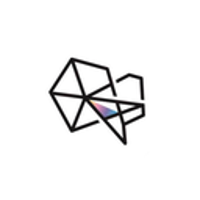
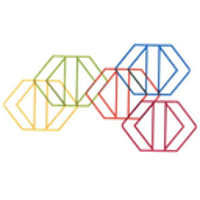
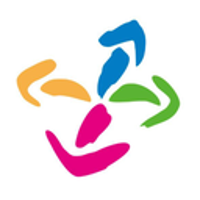
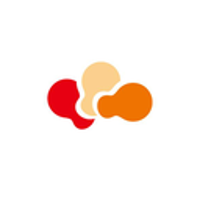
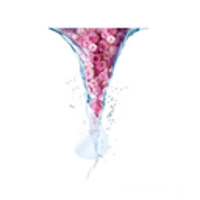
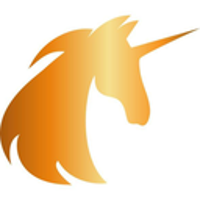
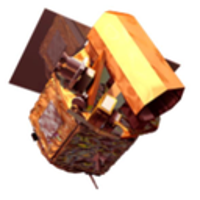
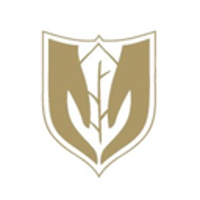
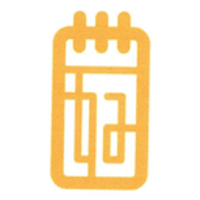
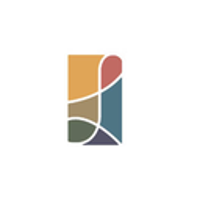
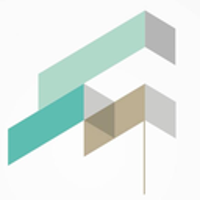
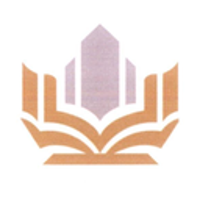
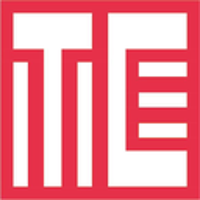
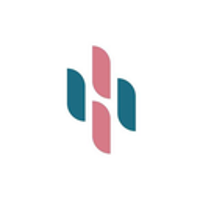
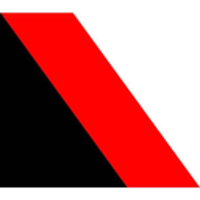
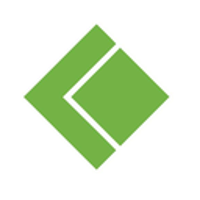
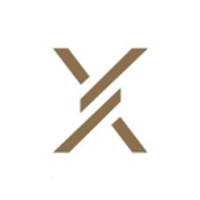
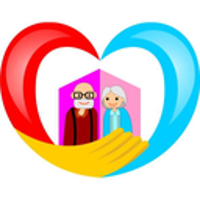
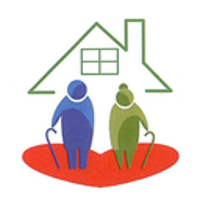
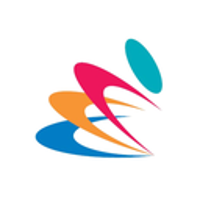
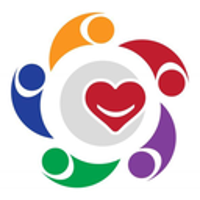
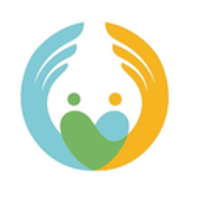
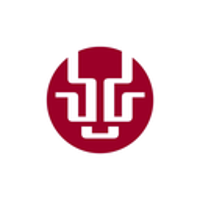
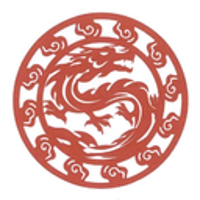
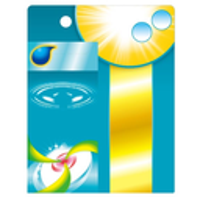
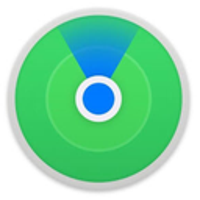
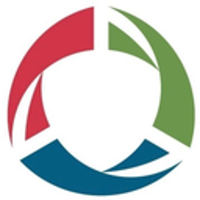
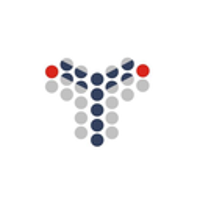
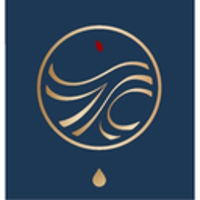
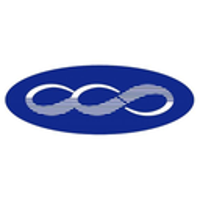
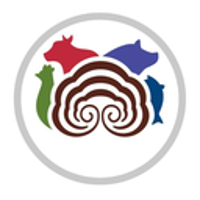
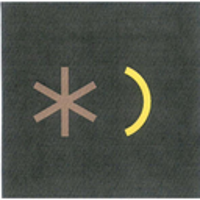
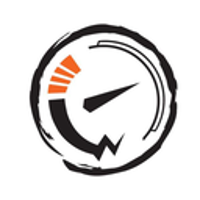
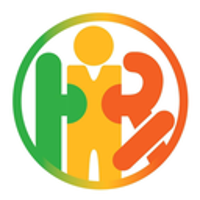
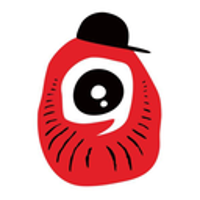
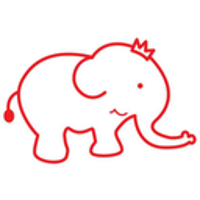
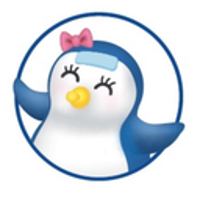
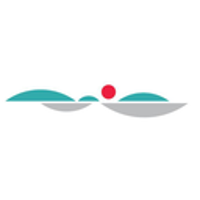
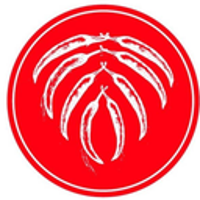
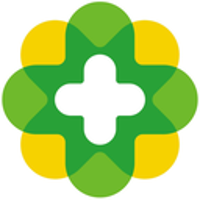
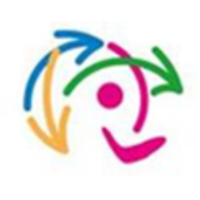
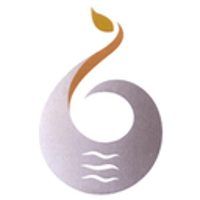
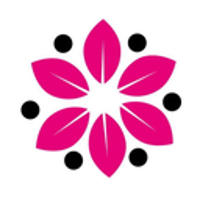
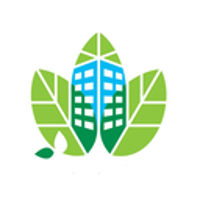
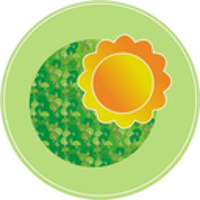
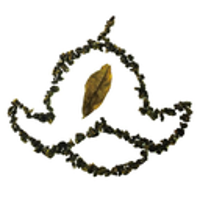
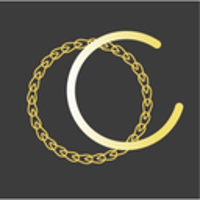
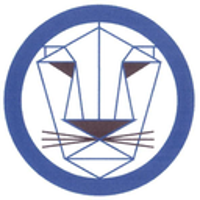
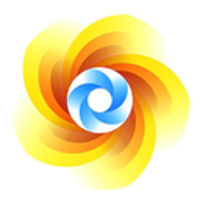
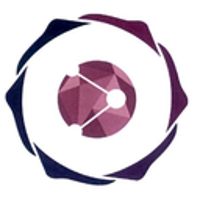
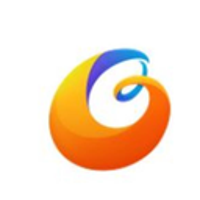
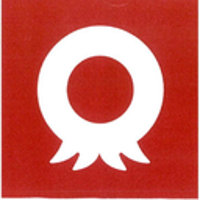
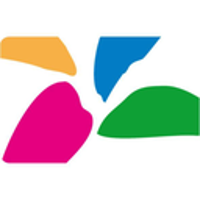
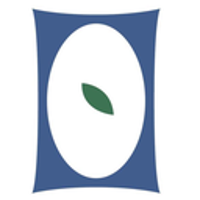
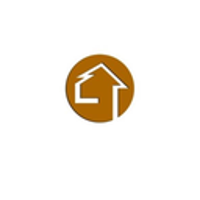
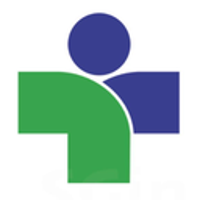
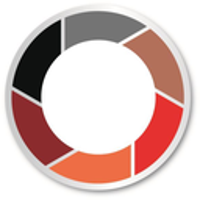
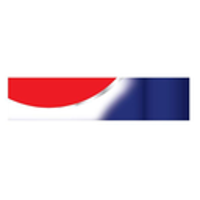
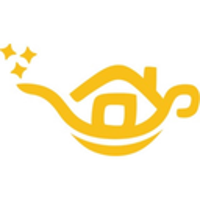
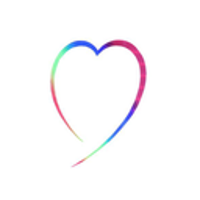
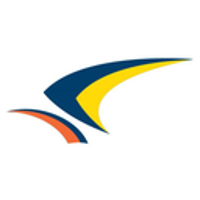
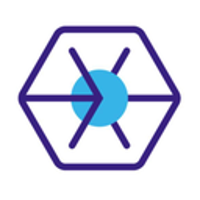
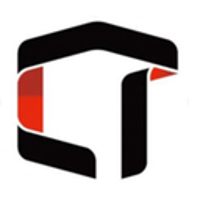
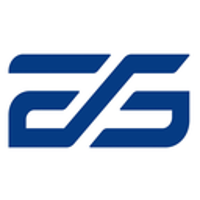
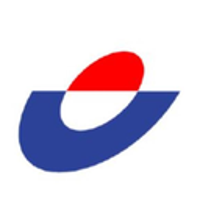
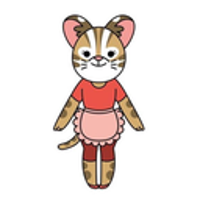
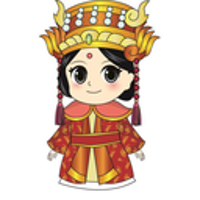
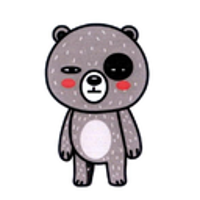
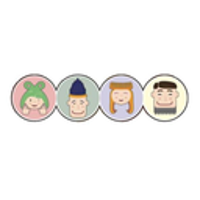
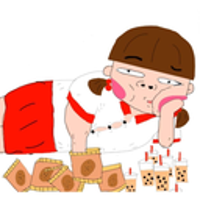
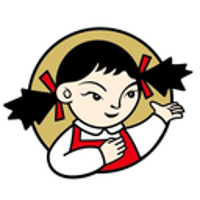
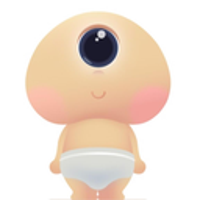
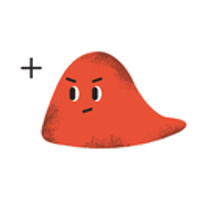
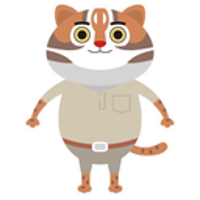
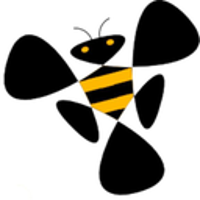
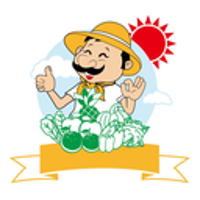
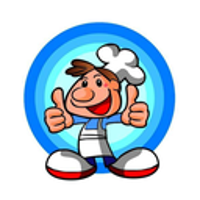
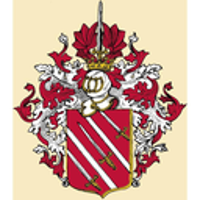
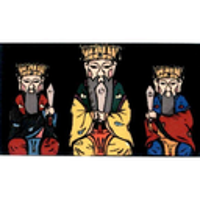
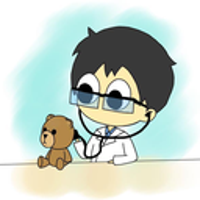
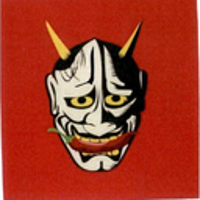
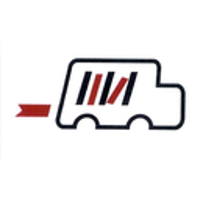
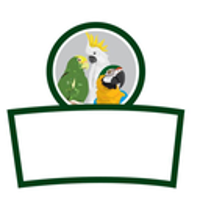
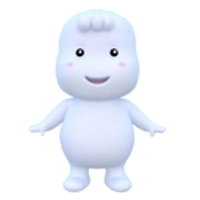
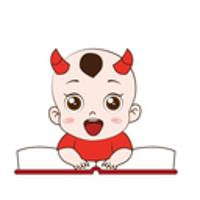
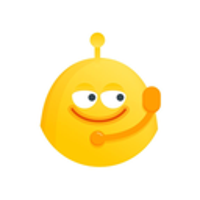
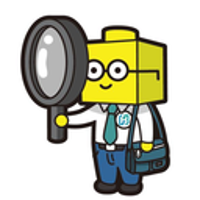
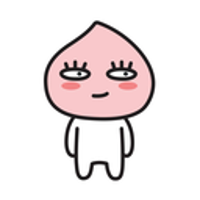
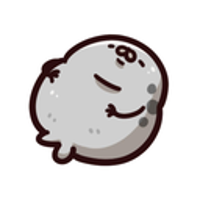
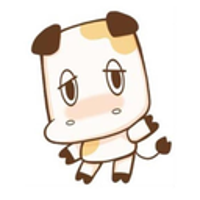
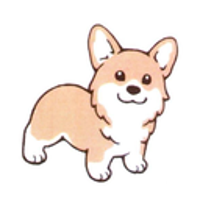
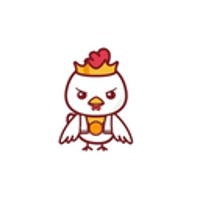
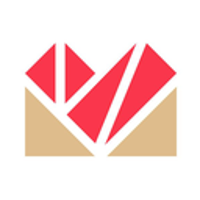
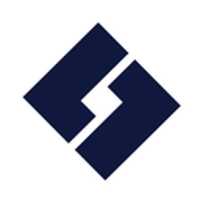
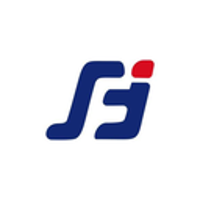
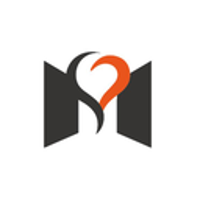
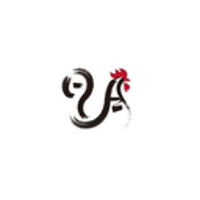
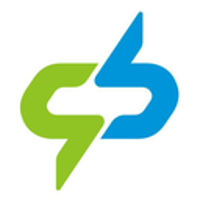
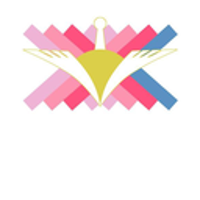
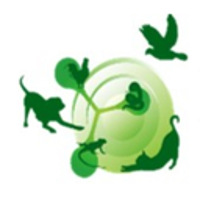
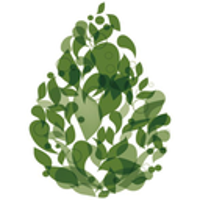
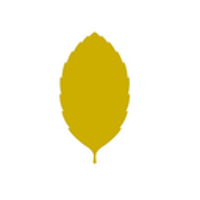
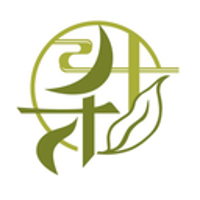
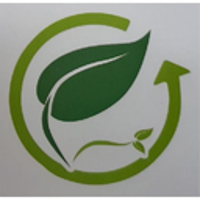
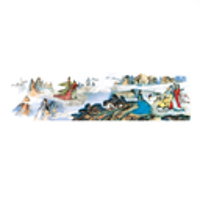
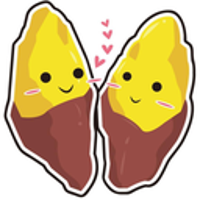
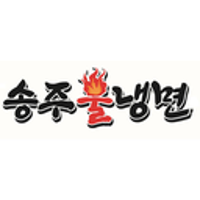
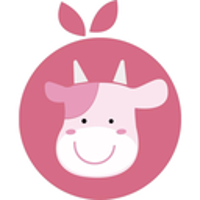
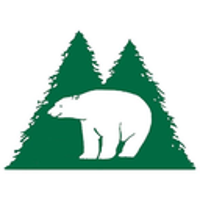
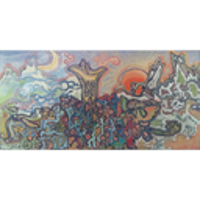


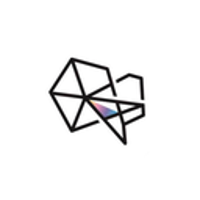
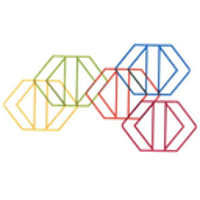
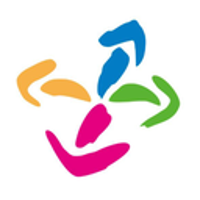
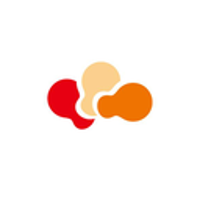
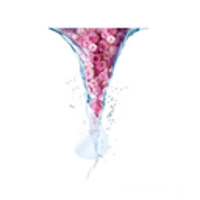
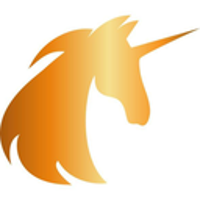
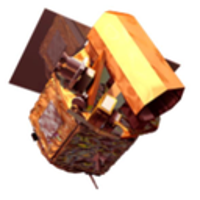
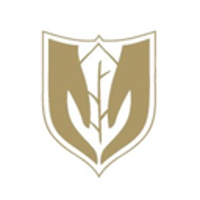
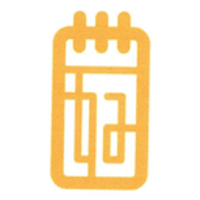
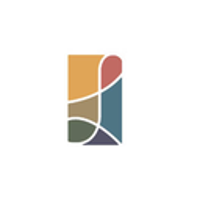
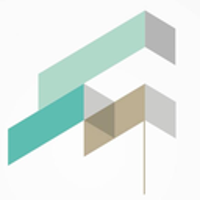
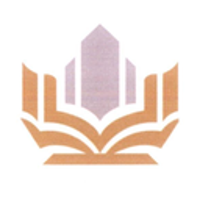
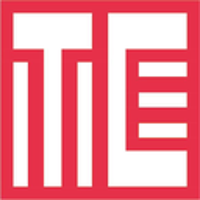
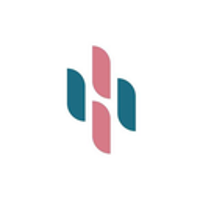
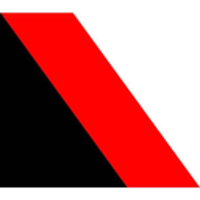
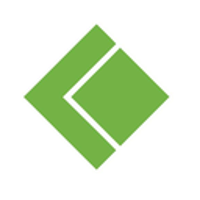
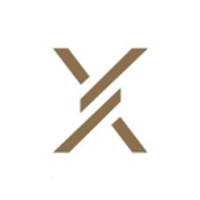
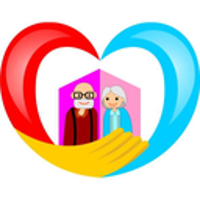
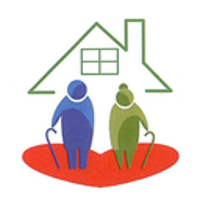
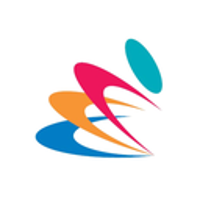
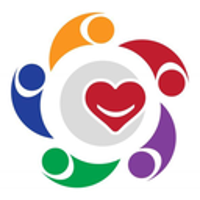
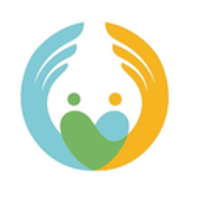
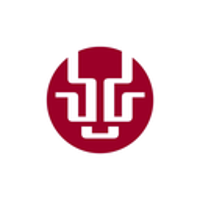
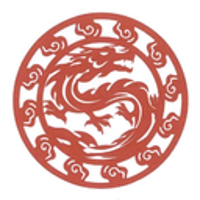
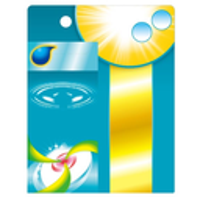
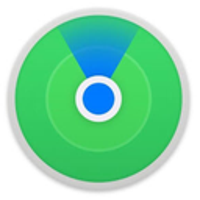
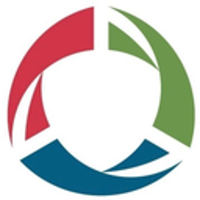
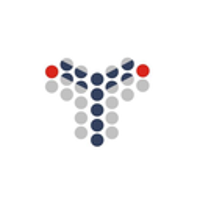
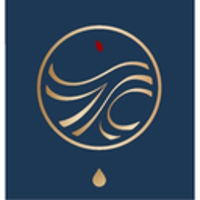
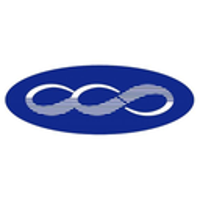
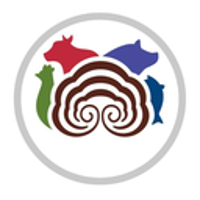
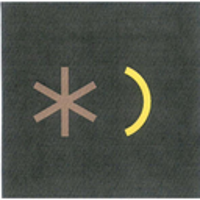
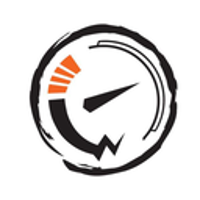
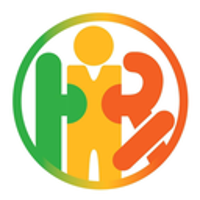
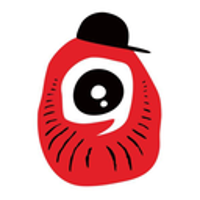
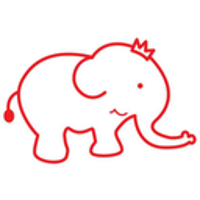
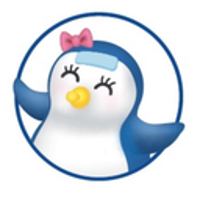
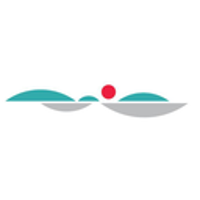
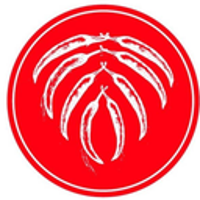
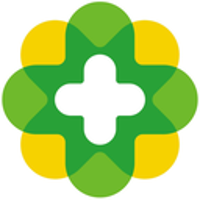
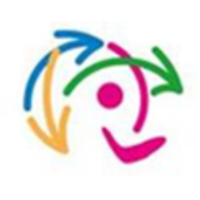
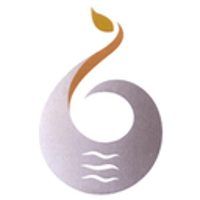
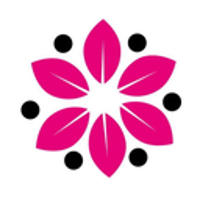
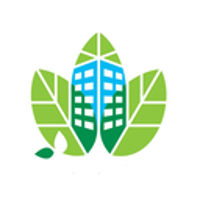
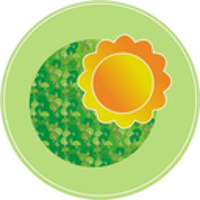
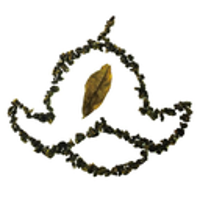
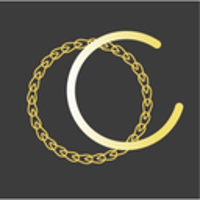
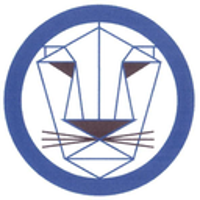
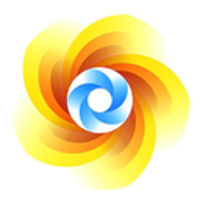
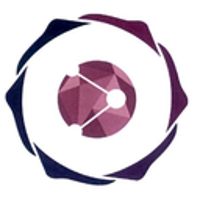
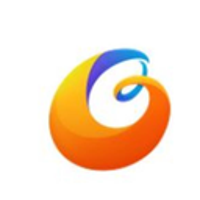
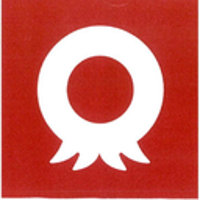
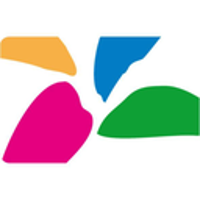
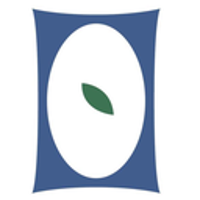
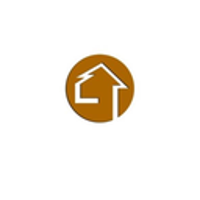
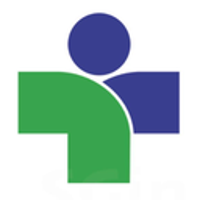
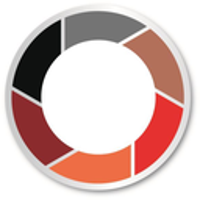
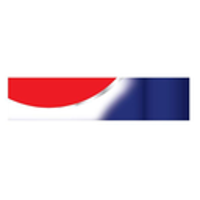
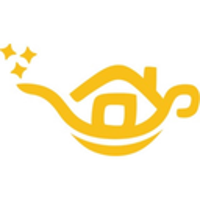
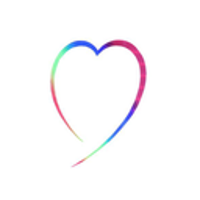
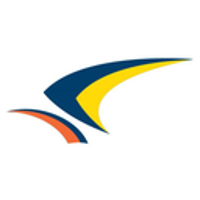
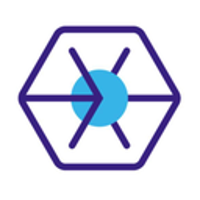
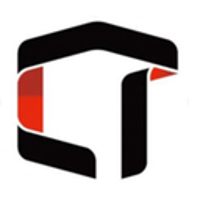
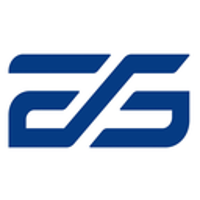
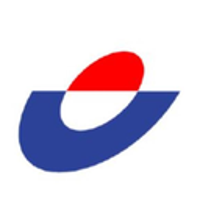
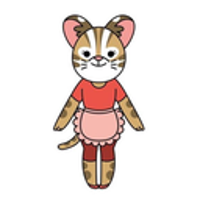
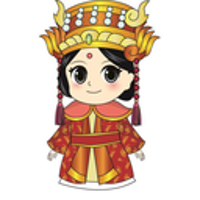
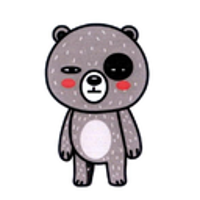
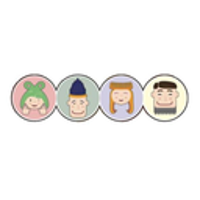
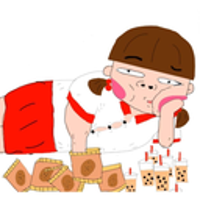
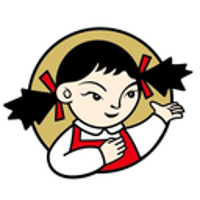
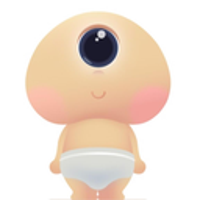
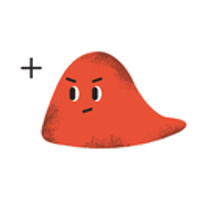
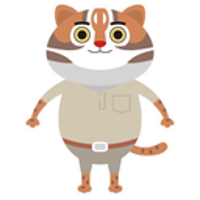
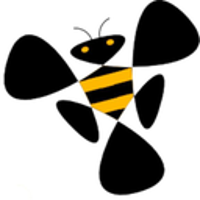
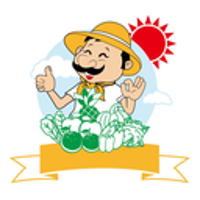
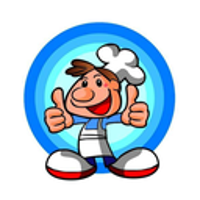
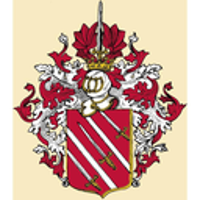
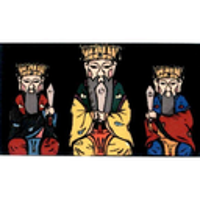
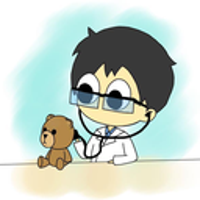
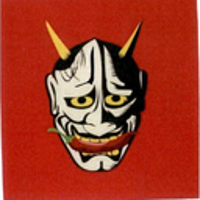
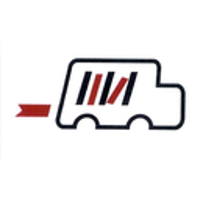
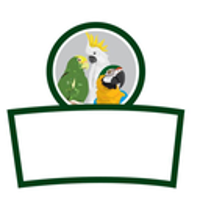
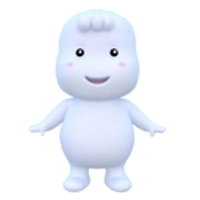
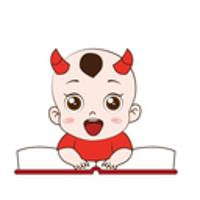
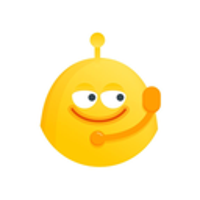
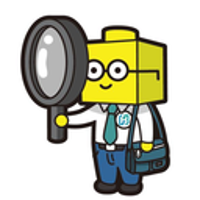
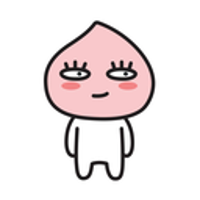
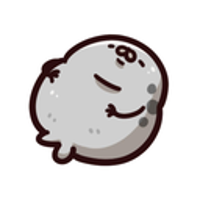
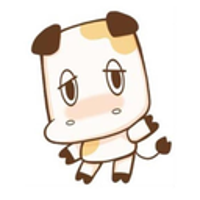
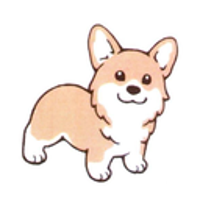
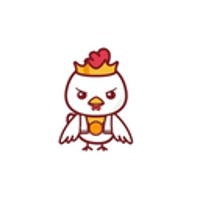
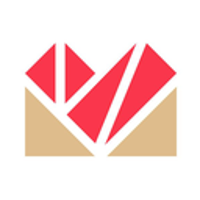
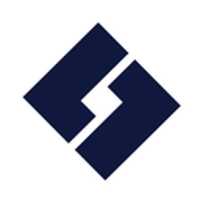
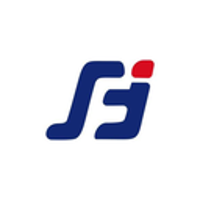
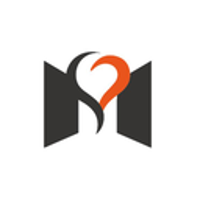
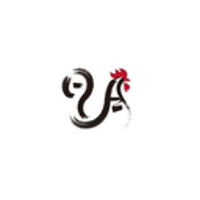
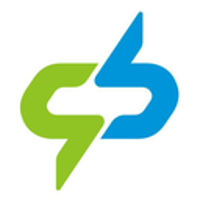
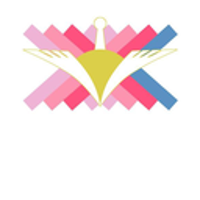
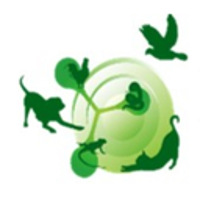
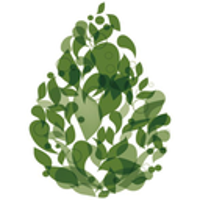
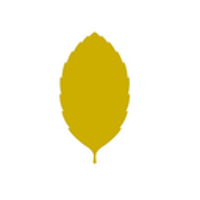
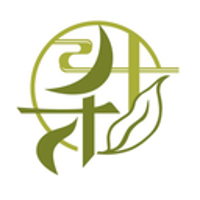
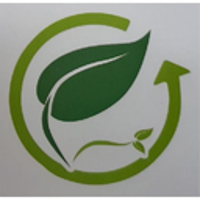
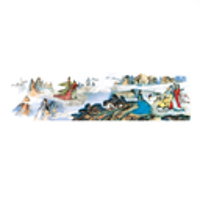
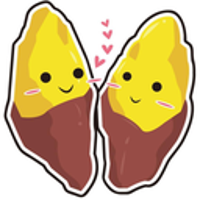
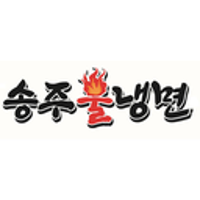
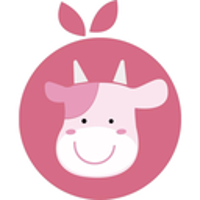
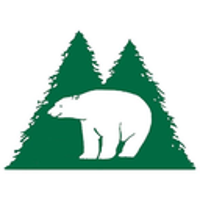
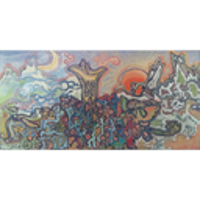

In [236]:
threshold = 0.3
title = []
imgs = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        model.eval()
        if i % 20 == 1:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs).cpu()
            outputs = outputs.numpy()
            labels = test_loader.dataset.label_code[(outputs[0])>threshold].tolist()
            if len(labels) == 0:
                labels = [ test_loader.dataset.label_code[np.argmax(outputs[0])]]
            img = Image.open(test_loader.dataset.path[i][0])
            img = img.resize((128,128),Image.ANTIALIAS)
    #             display(img)
            label = [labels_dict[i] for i in labels]
    #             img = inputs.cpu().squeeze().numpy()
    #             img = np.transpose(img, (1, 2, 0))
    #             plt.imshow((img))
    #             plt.show()

    #             print(f"pred labels : {' ; '.join(label)}")
            gd = test_loader.dataset.label_code[test_loader.dataset.labels[i]>0]
    #             print(f"ground truth: {' ; '.join([labels_dict[i] for i in gd])}")

            title.append("Pred Labels : {}  Ground Truth: {}".format(' ; '.join(label), ' ; '.join([labels_dict[i] for i in gd])))
            imgs.append(img)
ipyplot.plot_class_representations(imgs, title, img_width=200)